In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import numpy as np

import defmod as dm
import multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.hamiltonian_multishape as hamiltonian
import model_graddesc as model
import defmod.registrationdata as regdata

torch.set_default_tensor_type(torch.DoubleTensor)

In [4]:
source_vertices = torch.tensor([[1.,5.],[5.,5.],[8.,6.]])
target_vertices = torch.tensor([[1.,7.],[5.,5.],[8.,6.]])
nb_pts = [4,4]

data = regdata.part_rigid(source_vertices, target_vertices, nb_pts)
data.build_source()
#data.build_target()
data.build_shot_target()
data.build_modules()

source = data.source
target = data.target

reduced
eps 0.05
sigma 0.5
[<defmod.deformationmodules.SilentPoints object at 0x7f2d04ccb630>, <defmod.deformationmodules.SilentPoints object at 0x7f2d04ccb6d8>]
red background gd [tensor([5.0541, 4.6667, 4.9459, 5.3333, 4.8377, 6.0000, 5.1623, 4.0000],
       grad_fn=<CloneBackward>)]
constr tensor([[-3.7371e-11,  1.0017e-10],
        [ 3.7887e-11,  9.4830e-11],
        [ 6.0019e-11,  2.8360e-11],
        [-6.3346e-11,  2.5193e-11],
        [-7.1363e-11, -1.8554e-11],
        [ 6.7234e-11, -5.8918e-11],
        [-7.2007e-11, -4.4341e-11],
        [-7.7149e-12, -2.6474e-11]], grad_fn=<CatBackward>)
mod copy___________________________
reduced
eps 0.05
sigma 0.5
[<defmod.deformationmodules.SilentPoints object at 0x7f2d04cd6630>, <defmod.deformationmodules.SilentPoints object at 0x7f2d04cd6668>]
red background gd [tensor([5.0541, 4.6667, 4.9459, 5.3333, 4.8377, 6.0000, 5.1623, 4.0000],
       grad_fn=<CloneBackward>)]
numel_gd 8
[tensor([5.0541, 4.6667, 4.9459, 5.3333, 4.8377, 6.0000, 5.1

       grad_fn=<AddBackward0>)] [[tensor([5.0437, 4.8273, 4.9355, 5.4939, 4.8436, 6.1456, 5.1641, 4.1467],
       grad_fn=<AddBackward0>), tensor([5.0437, 4.8273, 4.9355, 5.4939, 4.8436, 6.1456, 3.5773, 6.2314, 2.3003,
        6.2633, 1.0137, 6.2745, 1.0018, 5.6110, 0.9877, 4.9444, 0.9757, 4.2746,
        2.3555, 4.2614, 3.7462, 4.2265, 5.1641, 4.1467],
       grad_fn=<AddBackward0>), tensor([5.0437, 4.8273, 4.9355, 5.4939, 4.8436, 6.1456, 3.5773, 6.2314, 2.3003,
        6.2633, 1.0137, 6.2745, 1.0018, 5.6110, 0.9877, 4.9444, 0.9757, 4.2746,
        2.3555, 4.2614, 3.7462, 4.2265, 5.1641, 4.1467],
       grad_fn=<AddBackward0>), tensor([5.0437, 4.8273, 4.9355, 5.4939, 4.8436, 6.1456, 5.1641, 4.1467],
       grad_fn=<AddBackward0>), tensor([5.0437, 4.8273, 4.9355, 5.4939, 4.8436, 6.1456, 3.5773, 6.2314, 2.3003,
        6.2633, 1.0137, 6.2745, 1.0018, 5.6110, 0.9877, 4.9444, 0.9757, 4.2746,
        2.3555, 4.2614, 3.7462, 4.2265, 5.1641, 4.1467],
       grad_fn=<AddBackward0>)], [tensor(

constr tensor([[ 2.4117e-11,  2.6679e-11],
        [ 3.2020e-09,  9.2878e-10],
        [ 1.5971e-09, -1.5605e-10],
        [-2.1099e-11,  2.0509e-11],
        [-2.3305e-09, -4.2458e-10],
        [ 5.8693e-11, -7.7686e-10],
        [-5.7780e-12, -1.0538e-12],
        [ 2.7756e-17,  2.2204e-16]], grad_fn=<CatBackward>)
mod copy___________________________
reduced
eps 0.05
sigma 0.5
[<defmod.deformationmodules.SilentPoints object at 0x7f2d04cdd0f0>, <defmod.deformationmodules.SilentPoints object at 0x7f2d04cdd860>]
red background gd [tensor([5.0306, 4.9876, 4.9224, 5.6543, 4.8571, 6.2735, 5.1716, 4.3094, 4.9653,
        5.6068, 5.1042, 4.1718], grad_fn=<CloneBackward>)]
numel_gd 12
[tensor([5.0306, 4.9876, 4.9224, 5.6543, 4.8571, 6.2735, 5.1716, 4.3094, 4.9653,
        5.6068, 5.1042, 4.1718], grad_fn=<CloneBackward>)]
8
[tensor([5.0306, 4.9876, 4.9653, 5.6068, 4.8471, 6.3094, 5.1042, 4.1718],
       grad_fn=<AddBackward0>)]
mod copy bg gd [tensor([5.0306, 4.9876, 4.9224, 5.6543, 4.8571, 6

d_gd Hamiltonian______________________
[[tensor([-1.1231, -3.6578, -0.2340,  3.1929, -2.6217,  5.2035, -2.5792, -4.1873],
       grad_fn=<AddBackward0>), tensor([-0.0078, -0.0006, -0.0079, -0.0006, -0.0080, -0.0006, -0.0080, -0.0006,
        -0.0078, -0.0006, -0.0077, -0.0006, -0.0078, -0.0005, -0.0079, -0.0005,
        -0.0080, -0.0006, -0.0079, -0.0005, -0.0078, -0.0006, -0.0077, -0.0007],
       grad_fn=<AddBackward0>), tensor([ 0.5323, -0.0364,  0.5387, -0.0382,  0.5444, -0.0346,  0.5414, -0.0404,
         0.5327, -0.0417,  0.5283, -0.0359,  0.5335, -0.0434,  0.5402, -0.0441,
         0.5465, -0.0374,  0.5377, -0.0446,  0.5279, -0.0411,  0.5277, -0.0300],
       grad_fn=<AddBackward0>), tensor([-6.8768e-09,  3.7422e-08,  2.6433e-07, -3.2444e-06, -2.6114e-07,
         3.2216e-06,  3.8222e-09, -1.7295e-08], grad_fn=<AddBackward0>), tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0438, -0.1522,  0.0481, -0.0693,  0.0589,  0.

d_gd Hamiltonian______________________
[[tensor([-1.3279, -3.8612, -0.1075,  3.2829, -2.1154,  5.0804, -2.3902, -4.1898],
       grad_fn=<AddBackward0>), tensor([-0.0077, -0.0009, -0.0078, -0.0009, -0.0079, -0.0009, -0.0079, -0.0009,
        -0.0077, -0.0009, -0.0076, -0.0010, -0.0077, -0.0008, -0.0078, -0.0008,
        -0.0079, -0.0009, -0.0078, -0.0008, -0.0077, -0.0009, -0.0076, -0.0011],
       grad_fn=<AddBackward0>), tensor([ 0.4820, -0.0155,  0.4885, -0.0180,  0.4939, -0.0151,  0.4922, -0.0199,
         0.4834, -0.0206,  0.4785, -0.0148,  0.4836, -0.0227,  0.4904, -0.0238,
         0.4970, -0.0175,  0.4886, -0.0248,  0.4786, -0.0208,  0.4778, -0.0087],
       grad_fn=<AddBackward0>), tensor([-1.7817e-08,  7.1543e-08,  1.7105e-06, -8.7388e-05, -1.7081e-06,
         8.7336e-05,  1.4722e-08, -5.0778e-08], grad_fn=<AddBackward0>), tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0383, -0.1217,  0.0433, -0.0587,  0.0539,  0.

d_gd Hamiltonian______________________
[[tensor([-1.4301, -3.9718, -0.0497,  3.3221, -1.8466,  4.9719, -2.2405, -4.1678],
       grad_fn=<AddBackward0>), tensor([-0.0076, -0.0011, -0.0077, -0.0010, -0.0078, -0.0011, -0.0078, -0.0010,
        -0.0077, -0.0010, -0.0076, -0.0011, -0.0076, -0.0010, -0.0077, -0.0010,
        -0.0078, -0.0010, -0.0078, -0.0010, -0.0076, -0.0010, -0.0076, -0.0012],
       grad_fn=<AddBackward0>), tensor([ 0.4521, -0.0029,  0.4580, -0.0054,  0.4626, -0.0030,  0.4618, -0.0070,
         0.4538, -0.0074,  0.4493, -0.0022,  0.4538, -0.0094,  0.4600, -0.0106,
         0.4659, -0.0050,  0.4585, -0.0117,  0.4495, -0.0078,  0.4486,  0.0034],
       grad_fn=<AddBackward0>), tensor([-3.7992e-08,  1.2543e-07, -1.0484e-05, -5.1863e-04,  1.0479e-05,
         5.1848e-04,  3.4867e-08, -1.0436e-07], grad_fn=<AddBackward0>), tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0360, -0.1021,  0.0407, -0.0503,  0.0499,  0.

d_gd Hamiltonian______________________
[[tensor([-1.5293e+00, -4.0838e+00,  3.1742e-03,  3.3534e+00, -1.5754e+00,
         4.8295e+00, -2.0553e+00, -4.1251e+00], grad_fn=<AddBackward0>), tensor([-0.0076, -0.0012, -0.0076, -0.0012, -0.0077, -0.0012, -0.0077, -0.0012,
        -0.0076, -0.0012, -0.0075, -0.0012, -0.0076, -0.0011, -0.0076, -0.0011,
        -0.0077, -0.0012, -0.0077, -0.0011, -0.0076, -0.0012, -0.0075, -0.0013],
       grad_fn=<AddBackward0>), tensor([0.4198, 0.0110, 0.4245, 0.0085, 0.4280, 0.0104, 0.4280, 0.0074, 0.4217,
        0.0073, 0.4179, 0.0115, 0.4215, 0.0056, 0.4265, 0.0046, 0.4313, 0.0090,
        0.4255, 0.0036, 0.4181, 0.0068, 0.4171, 0.0161],
       grad_fn=<AddBackward0>), tensor([-9.2165e-08,  2.5188e-07, -2.1001e-04, -3.0909e-03,  2.0994e-04,
         3.0902e-03,  8.9008e-08, -2.3053e-07], grad_fn=<AddBackward0>), tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0339, -0.0804,  0.0377, -0.0402,  0.

In [18]:
man = dm.manifold.Landmarks(2,1)
comp = dm.deformationmodules.CompoundModule([dm.deformationmodules.SilentPoints(man), dm.deformationmodules.Translations(man, 1.)])
modules = dm.multishape.MultiShapeModule([comp, comp], 1.)

In [43]:
modules.manifold.gd

[[tensor([0., 0.], grad_fn=<ViewBackward>)],
 [tensor([0., 0.], grad_fn=<ViewBackward>)],
 [tensor([0., 0.], grad_fn=<CloneBackward>),
  tensor([0., 0.], grad_fn=<CloneBackward>)]]

In [44]:
mod_copy = modules.copy()
mod_copy.manifold.gd

[[tensor([0., 0.], grad_fn=<ViewBackward>)],
 [tensor([0., 0.], grad_fn=<ViewBackward>)],
 [tensor([0., 0.], grad_fn=<CloneBackward>),
  tensor([0., 0.], grad_fn=<CloneBackward>)]]

In [20]:
constr = dm.constraints.Identity_Silent()
h = dm.hamiltonian_multishape.Hamiltonian_multi(modules, constr)

In [21]:
h.module.module_list[0].module_list

In [29]:
h.module.manifold[0][0].fill_cotan(torch.ones_like(h.module.manifold[0].cotan[0]))
h.geodesic_controls()
h.module.controls

torch.Size([2, 2]) torch.Size([2, 2])
torch.Size([2, 2]) torch.Size([2, 2])


[[tensor([], requires_grad=True),
  tensor([1.3333, 1.3333], grad_fn=<ViewBackward>)],
 [tensor([], requires_grad=True),
  tensor([1.3333, 1.3333], grad_fn=<ViewBackward>)],
 [tensor([0.6667, 0.6667], grad_fn=<SubBackward0>),
  tensor([0.6667, 0.6667], grad_fn=<SubBackward0>)]]

In [47]:
dm.shooting.shoot_euler(h, it=10)

[<defmod.manifold.Landmarks object at 0x7f2d04c9fa90>, <defmod.manifold.Landmarks object at 0x7f2d04c9fac8>]
torch.Size([2, 2]) torch.Size([2, 2])
torch.Size([2, 2]) torch.Size([2, 2])
constr tensor([[0., 0.],
        [0., 0.]], grad_fn=<CatBackward>)
d_gd Hamiltonian______________________
[[tensor([0., 0.], grad_fn=<AddBackward0>), tensor([0., 0.], grad_fn=<AddBackward0>)], [tensor([0., 0.], grad_fn=<AddBackward0>), tensor([0., 0.], grad_fn=<AddBackward0>)], [tensor([0., 0.], grad_fn=<AddBackward0>), tensor([0., 0.], grad_fn=<AddBackward0>)]]
d_gd field generator__________________
[[tensor([[1.3333, 1.3333],
        [1.3333, 1.3333]], grad_fn=<AddBackward0>), tensor([[1.3333, 1.3333],
        [1.3333, 1.3333]], grad_fn=<AddBackward0>)], [tensor([[1.3333, 1.3333],
        [1.3333, 1.3333]], grad_fn=<AddBackward0>), tensor([[1.3333, 1.3333],
        [1.3333, 1.3333]], grad_fn=<AddBackward0>)], [tensor([[1.3333, 1.3333],
        [1.3333, 1.3333]], grad_fn=<AddBackward0>), tensor([[1.3333

d_gd Hamiltonian______________________
[[tensor([0., 0.], grad_fn=<AddBackward0>), tensor([0., 0.], grad_fn=<AddBackward0>)], [tensor([0., 0.], grad_fn=<AddBackward0>), tensor([0., 0.], grad_fn=<AddBackward0>)], [tensor([0., 0.], grad_fn=<AddBackward0>), tensor([0., 0.], grad_fn=<AddBackward0>)]]
d_gd field generator__________________
[[tensor([[1.3333, 1.3333],
        [1.3333, 1.3333]], grad_fn=<AddBackward0>), tensor([[1.3333, 1.3333],
        [1.3333, 1.3333]], grad_fn=<AddBackward0>)], [tensor([[1.3333, 1.3333],
        [1.3333, 1.3333]], grad_fn=<AddBackward0>), tensor([[1.3333, 1.3333],
        [1.3333, 1.3333]], grad_fn=<AddBackward0>)], [tensor([[0.7031, 0.7031],
        [0.7031, 0.7031]], grad_fn=<AddBackward0>), tensor([[0.7031, 0.7031],
        [0.7031, 0.7031]], grad_fn=<AddBackward0>)]]
d_gd action________________________
[[tensor([128.0000, 128.0000], requires_grad=True), tensor([128.0000, 128.0000], requires_grad=True)], [tensor([128.0000, 128.0000], requires_grad=True)

([<defmod.manifold.CompoundManifold at 0x7f2d04bfd7f0>,
 [[[tensor([], requires_grad=True),
    tensor([1.3333, 1.3333], grad_fn=<ViewBackward>)],
   [tensor([], requires_grad=True),
    tensor([1.3333, 1.3333], grad_fn=<ViewBackward>)],
   [tensor([0.6667, 0.6667], grad_fn=<SubBackward0>),
    tensor([0.6667, 0.6667], grad_fn=<SubBackward0>)]],
  [[tensor([], requires_grad=True),
    tensor([1.3333, 1.3333], grad_fn=<ViewBackward>)],
   [tensor([], requires_grad=True),
    tensor([1.3333, 1.3333], grad_fn=<ViewBackward>)],
   [tensor([0.6667, 0.6667], grad_fn=<SubBackward0>),
    tensor([0.6667, 0.6667], grad_fn=<SubBackward0>)]],
  [[tensor([], requires_grad=True),
    tensor([1.3333, 1.3333], grad_fn=<ViewBackward>)],
   [tensor([], requires_grad=True),
    tensor([1.3333, 1.3333], grad_fn=<ViewBackward>)],
   [tensor([0.6667, 0.6667], grad_fn=<SubBackward0>),
    tensor([0.6667, 0.6667], grad_fn=<SubBackward0>)]],
  [[tensor([], requires_grad=True),
    tensor([1.3333, 1.3333], gra

In [53]:
h.module.manifold[-1].manifold_list, h.module.copy().manifold[-1].manifold_list

([<defmod.manifold.Landmarks at 0x7f5659ce4c18>,
  <defmod.manifold.Landmarks at 0x7f5659ce61d0>])

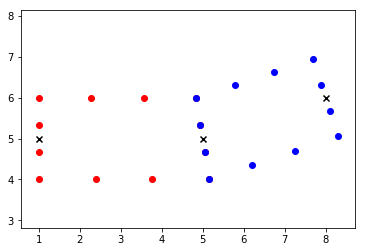

In [3]:
# Visualization of the source shape
# The shape is defined by the points at the black crosses

x = data.source[0].clone()
y = data.source[1].clone()

plt.figure()
plt.scatter(x[:, 0].detach().numpy(), x[:, 1].detach().numpy(), c='red')
plt.scatter(y[:, 0].detach().numpy(), y[:, 1].detach().numpy(), c='blue')
plt.scatter(source_vertices[:, 0].detach().numpy(), source_vertices[:, 1].detach().numpy(), c='k', marker='x')

plt.axis('equal')
plt.show()

In [4]:
# Visualization of the source and target
plt.figure()
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red', marker='x')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue', marker='+')
plt.axis([0,9,0,9])

plt.figure()
plt.scatter(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), c='red', marker='x')
plt.scatter(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), c='blue', marker='+')



plt.axis([0,9,0,9])
plt.show()

NameError: name 'source' is not defined

In [6]:
# Definition of the multi shape module and Hamiltonian
modules = dm.multishape.MultiShapeModule([data.modules[0], data.modules[1]], sigma_background=5., reduce_background=True)
modules.fill_controls_zero()
constr_Id = dm.constraints.Identity_Silent_reduced()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [7]:
# Definition of the similarity metric
from defmod.attachement import L2NormAttachement

def attach(modules, target):
    return sum([L2NormAttachement()( modules.module_list[i][-1].manifold.gd.view(-1,2), target[i]) for i in range(len(target))])

In [ ]:
gd0 = modules.module_list[0].manifold[0].gd
gd1 = modules.module_list[1].manifold[0].gd
gd2 = modules.module_list[-1].manifold.gd[0]

gd_silent = torch.cat([gd0,gd1,gd2]).view(-1,1)

In [ ]:
modules.module_list[0].module_list[-1].manifold.cotan.view(-1,2)

In [ ]:
modules.module_list[0][1].manifold.fill_cotan(torch.rand_like(modules.module_list[0][1].manifold.cotan))
H.geodesic_controls()

In [ ]:
dm.shooting.shoot_euler(H, it=10)

In [ ]:
H.geodesic_controls()
dm.constraints.Identity_Silent_reduced().call_by_matmul(modules)

In [ ]:
modules.manifold.fill_cotan(torch.zeros_like(torch.cat(modules.manifold.unroll_cotan())))
H.geodesic_controls()

In [ ]:
gd0_tensor = torch.cat(H.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
mom0_tensor = torch.cat(H.module.manifold.unroll_cotan().copy(),0).requires_grad_().view(-1)
    
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
    
EnergyFunctional = model.EnergyFunctional(modules, H, constr_Id,source, target, 2, gamma=10**-3, attach=attach)


In [ ]:
def fun(P, *args):
    #EnergyFunctional = args[0]
    Y = torch.tensor(P).requires_grad_()
    return EnergyFunctional.energy_tensor(gd0_tensor, Y).detach().numpy()[0]

In [ ]:
def jac(P):
    #EnergyFunctional = args[0]
    Y = torch.tensor(P).requires_grad_()
    return EnergyFunctional.gradE_autograd(gd0_tensor, Y).detach().numpy()

In [ ]:
import scipy.optimize
res = scipy.optimize.minimize(fun, mom0_tensor.detach().numpy(),
                              method='BFGS',
                              jac=jac,
                              bounds=None,
                              tol=None,
                              callback=None,
                              options={
                                  'maxcor': 10,
                                  'ftol': 1.e-09,
                                  'gtol': 1e-03,
                                  'eps': 1e-08,
                                  'maxfun': 500,
                                  'maxiter': 50,
                                  'iprint': 1,
                                  'maxls': 25
                              })

In [ ]:
P_opt = res.x
X = [gd0_tensor, torch.tensor(P_opt)]

In [ ]:
%matplotlib inline
H.module.manifold.fill_gd(X[0])
H.module.manifold.fill_cotan(X[1])

states, controls = dm.shooting.shoot_euler(H, it=10)

In [ ]:
H.module.manifold.fill_gd(states[0].gd)

In [ ]:
print(H.module.manifold.gd)
print(states[0].gd)

In [ ]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(states)))

plt.figure()
for s,c in zip(states, colors):
    plt.figure()
    c = 'b'
    plt.scatter(s[0][-1].gd.view(-1,2)[:, 0].detach().numpy(), s[0][-1].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s[1][-1].gd.view(-1,2)[:, 0].detach().numpy(), s[1][-1].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    #plt.scatter(s[2][0].gd.view(-1,2)[:, 0].detach().numpy(), s[2][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    #plt.scatter(s[2][1].gd.view(-1,2)[:, 0].detach().numpy(), s[2][1].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.plot(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), 'xk')
    plt.plot(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), 'xk')

    plt.plot(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), '.k')
    plt.plot(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), '.k')


    plt.axis('equal')
    plt.show()

In [ ]:
modules.controls

In [ ]:
plt.close('all')

In [ ]:
# Visualization of grid deformation for each submodule
nx, ny = 10,10
sx, sy = 10,10
x, y = torch.meshgrid([torch.arange(0, nx), torch.arange(0, ny)])
x = sx*(x.type(torch.DoubleTensor)/nx)
y = sy*(y.type(torch.DoubleTensor)/ny)

gridpoints = dm.usefulfunctions.grid2vec(x, y).type(torch.DoubleTensor)

In [ ]:
plt.plot(source[0][:,0].detach().numpy(), source[0][:,1].detach().numpy())

In [ ]:
phi = mm.largeDeformation(modules, states, controls, gridpoints)

x1, y1 = dm.usefulfunctions.vec2grid(phi[0], nx, ny)
x2, y2 = dm.usefulfunctions.vec2grid(phi[1], nx, ny)
x3, y3 = dm.usefulfunctions.vec2grid(phi[2], nx, ny)

In [ ]:
def_source = mm.largeDeformation(modules, states, controls, source[0])


In [ ]:
mm.plot_grid( gridpoints[:,0].view(10,10).detach().numpy(), gridpoints[:,1].view(10,10).detach().numpy(), color = 'blue')
s = states[0]
c = 'r'
plt.scatter(s[0][-1].gd.view(-1,2)[:, 0].detach().numpy(), s[0][-1].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
plt.scatter(s[1][-1].gd.view(-1,2)[:, 0].detach().numpy(), s[1][-1].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
plt.figure()
#mm.plot_grid( x1.detach().numpy(), y1.detach().numpy(), color = 'blue')
plt.plot( x1.detach().numpy(), y1.detach().numpy(), color = 'blue')
s = states[-1]
c = 'r'
plt.scatter(s[0][-1].gd.view(-1,2)[:, 0].detach().numpy(), s[0][-1].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
plt.scatter(s[1][-1].gd.view(-1,2)[:, 0].detach().numpy(), s[1][-1].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
plt.scatter(def_source[0].view(-1,2)[:, 0].detach().numpy(), def_source[0].view(-1,2)[:, 1].detach().numpy(), c='y')


mm.plot_grid(x2.detach().numpy(), y2.detach().numpy(), color = 'blue')
mm.plot_grid( x3.detach().numpy(), y3.detach().numpy(), color = 'blue')
plt.show()


In [ ]:
i = 0
N = len(states) 
mod = modules.module_list[0].copy()
mod.manifold.fill(states[0][0])
speed = mod.field_generator()(mod.manifold.gd[-1].view(-1,2))
mod.manifold.gd[-1].view(-1,2) + 1/N * speed

In [ ]:
states[1][0][-1].gd

In [ ]:
states[0].action(mod[0]).gd

In [ ]:
def test_gradcheck_Hamiltonian():
    def hamiltonian(gd, mom):
        
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        H.geodesic_controls()
                
        return H()
    return torch.autograd.gradcheck(hamiltonian, (gd, mom), raise_exception=True)

gd = gd0_tensor
mom = 1000*torch.rand(mom0_tensor.shape)


test_gradcheck_Hamiltonian()

In [ ]:
def test_gradcheck_EnergyFunctional():
    def energy(gd, mom):

        return model.EnergyFunctional(H.module, H, constr_Id,source, target, 2, reg_param).energy_tensor(gd, mom)
    return torch.autograd.gradcheck(energy, (gd, mom), raise_exception=True)

gd = gd0_tensor
mom = mom0_tensor


test_gradcheck_EnergyFunctional()

In [ ]:
def test_gradcheck_shooting():
    def shooting(gd, mom):
        
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        
        intermediate_states, intermediate_controls = dm.shooting.shoot_euler(H, it=2)
        return H.module.manifold.unroll_cotan()
    return torch.autograd.gradcheck(shooting, (gd, mom), raise_exception=True,atol=1e-2)

test_gradcheck_shooting()

In [ ]:
def test_gradcheck_attachement():
    def attach(gd, mom):
        reg_param = 10**-3 

        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        energyfunc = model.EnergyFunctional(H.module, H, constr_Id,source, target, 2, reg_param)

        return energyfunc.attach() 
    return torch.autograd.gradcheck(attach, (gd, mom), raise_exception=True)

gd = torch.cat(H.module.manifold.unroll_gd(),0).requires_grad_().view(-1)
mom = torch.cat(H.module.manifold.unroll_cotan(),0).requires_grad_().view(-1)

test_gradcheck_attachement()

In [ ]:
def test_gradcheck_EnergyFunctional():
    def energy(gd, mom):
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        H.module.compute_geodesic_variables(constr_Id)
        return H.module.controls[0]
    return torch.autograd.gradcheck(energy, (gd, mom), raise_exception=True)

gd = torch.cat(H.module.manifold.unroll_gd(),0).requires_grad_().view(-1)
mom = torch.cat(H.module.manifold.unroll_cotan(),0).requires_grad_().view(-1)

test_gradcheck_EnergyFunctional()

In [ ]:
def test_gradcheck_autoaction():
    def autoaction(gd, mom):
        mod.manifold.fill_gd(gd)
        mod.manifold.fill_cotan(mom)
        return mod.autoaction()
    return torch.autograd.gradcheck(autoaction, (gd, mom), raise_exception=True)

mod = data.modules[0].copy()
gd = torch.cat(mod.manifold.gd.copy())
mom = torch.cat(mod.manifold.cotan.copy())

gd.requires_grad
mom.requires_grad

test_gradcheck_autoaction()

In [ ]:
modules.module_list[-1].autoaction()

In [ ]:
modules.background.costop_inv()

In [ ]:
torch.inverse(modules.background.K_q())

In [ ]:
modules.background.K_q() #- torch.eye(20)